In [2]:
!nvidia-smi -L

zsh:1: command not found: nvidia-smi


In [1]:
!wget https://raw.githubusercontent.com/mufaddalhamidofficial/tensorflow_course/main/helper.py

zsh:1: command not found: wget


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import cv2
import tensorflow_datasets as tfds

/Users/mufaddalhamid/Documents/Learn/TensorFlow/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# from helper_funcs import create_tensorboard_callback, load_and_prep_image, create_checkpoint_callback, plot_loss_curves, compare_historys
from helper_funcs import create_tensorboard_callback, load_and_prep_image, create_checkpoint_callback, plot_loss_curves, compare_historys

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
dataset_lists = tfds.list_builders()

2024-01-17 13:37:32.966185: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


In [5]:
'food101' in dataset_lists

True

In [6]:
(train_data, test_data), ds_info = tfds.load("food101",
                                             split=["train", "validation"],
                                             shuffle_files = True,
                                             as_supervised=True,
                                             with_info=True)

2024-01-17 13:37:36.747401: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-17 13:37:36.747425: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-17 13:37:36.747430: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-17 13:37:36.747493: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-17 13:37:36.747541: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir='/Users/mufaddalhamid/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train'

In [8]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

## Visualize Data

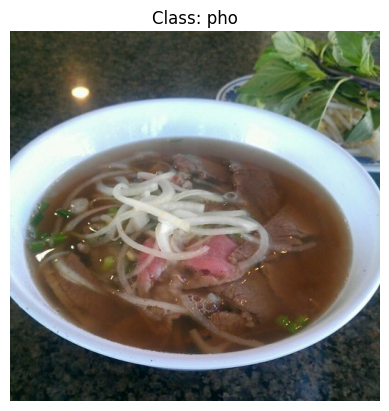

In [10]:
for image, label in train_data.take(1):
  plt.imshow(image)
  plt.title(f"Class: {class_names[label]}")
  plt.axis(False);

## Preprocess Data

In [11]:
def preprocess_img(img, label, img_shape = IMG_SIZE[0], scale = False):
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    img = img / 255.0
  return tf.cast(img, dtype=tf.float32), label

In [12]:
for image, label in train_data.take(1):
  print(preprocess_img(image, label));

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[238.7704   , 217.41327  , 155.4847   ],
        [242.83673  , 222.83673  , 162.55101  ],
        [240.85713  , 220.20918  , 164.2143   ],
        ...,
        [131.28564  , 118.28565  ,  75.7806   ],
        [123.88257  , 109.81113  ,  75.09689  ],
        [106.698746 ,  90.698746 ,  66.4131   ]],

       [[232.16325  , 212.09183  , 141.37755  ],
        [238.86224  , 219.86224  , 151.07654  ],
        [239.94388  , 221.08673  , 155.87245  ],
        ...,
        [127.49998  , 112.49998  ,  71.07145  ],
        [122.63767  , 106.56623  ,  72.852    ],
        [105.83142  ,  88.47424  ,  63.1886   ]],

       [[235.86224  , 217.07652  , 137.43367  ],
        [240.7143   , 223.7143   , 145.68367  ],
        [247.04591  , 229.26021  , 156.02551  ],
        ...,
        [126.68873  , 111.68873  ,  71.1173   ],
        [120.80094  , 104.7295   ,  71.01527  ],
        [105.57633  ,  88.29569  ,  62.581474 ]],

       ...,

    

## Batch and preprocess data

In [13]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and turn into batches and prefetch
train_data = train_data.shuffle(buffer_size=3000).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Work on test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating Callbacks

In [15]:
def create_checkpoint_callback(name: str):
  checkpoint_path = f"checkpoints/{name}/checkpoint.ckpt"
  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only = True,
    save_weights_only = True,
    verbose=0,
  )
  return model_checkpoint

## Mixed precision Training

In [16]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  METAL, no compute capability (probably not an Nvidia GPU)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  METAL, no compute capability (probably not an Nvidia GPU)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


## Building feature extraction model

In [18]:
input_shape = IMG_SIZE + (3,)


base_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation(activation="softmax", dtype = tf.float32)(x)
model_b_1 = tf.keras.Model(inputs, outputs)

model_b_1.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)



52606240/52606240 [==============================] - 0s 0us/step


In [19]:
model_b_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               155237    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
Total params: 13085859 (49.92 MB)
Trainable params: 155237 (6

In [20]:
for layer in model_b_1.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetv2-b3 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
activation True float32 <Policy "float32">


In [21]:
history_b_1 = model_b_1.fit(
    train_data,
    epochs=3,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[
        create_tensorboard_callback("tensorboard_callback", "07_baseline_1"),
        create_checkpoint_callback("07_baseline_1"),
    ],
)

Saving TensorBoard log files to: tensorboard_callback/07_baseline_1/20240115-153717
Epoch 1/3
2368/2368 [==============================] - 218s 80ms/step - loss: 1.7048 - accuracy: 0.5779 - val_loss: 1.1436 - val_accuracy: 0.6904
Epoch 2/3
2368/2368 [==============================] - 205s 84ms/step - loss: 1.2006 - accuracy: 0.6883 - val_loss: 1.0465 - val_accuracy: 0.7145
Epoch 3/3
2368/2368 [==============================] - 204s 83ms/step - loss: 1.0463 - accuracy: 0.7236 - val_loss: 0.9981 - val_accuracy: 0.7270


In [22]:
model_b_1.evaluate(test_data)

790/790 [==============================] - 59s 74ms/step - loss: 1.0179 - accuracy: 0.7244


[1.0178674459457397, 0.7244356274604797]

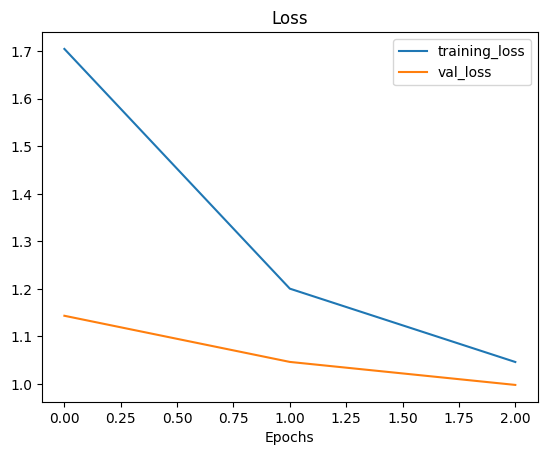

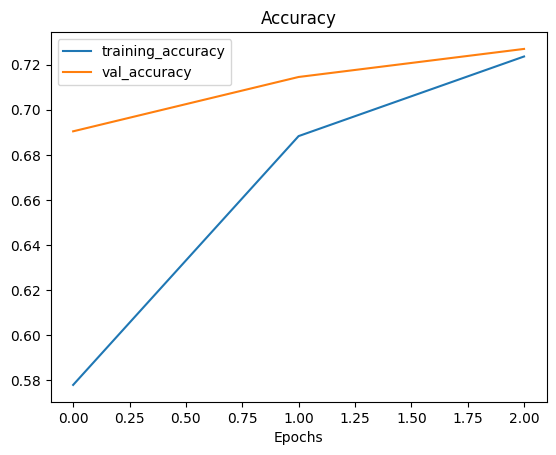

In [23]:
plot_loss_curves(history_b_1)


Saving TensorBoard log files to: tensorboard_callback/07_model_b_2/20240115-155402
Epoch 1/5
2368/2368 [==============================] - 207s 80ms/step - loss: 1.7028 - accuracy: 0.5777 - val_loss: 1.1281 - val_accuracy: 0.6984
Epoch 2/5
2368/2368 [==============================] - 204s 84ms/step - loss: 1.2002 - accuracy: 0.6869 - val_loss: 1.0326 - val_accuracy: 0.7097
Epoch 3/5
2368/2368 [==============================] - 199s 81ms/step - loss: 1.0463 - accuracy: 0.7253 - val_loss: 0.9998 - val_accuracy: 0.7238
Epoch 4/5
2368/2368 [==============================] - 215s 88ms/step - loss: 0.9436 - accuracy: 0.7509 - val_loss: 0.9714 - val_accuracy: 0.7296
Epoch 5/5
790/790 [==============================] - 56s 71ms/step - loss: 1.0059 - accuracy: 0.7275


[1.005947470664978, 0.7275247573852539]

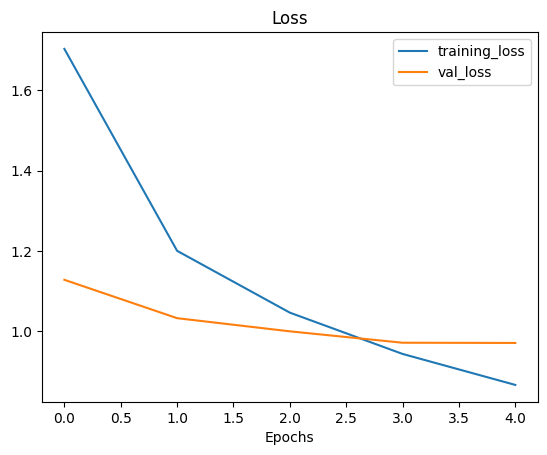

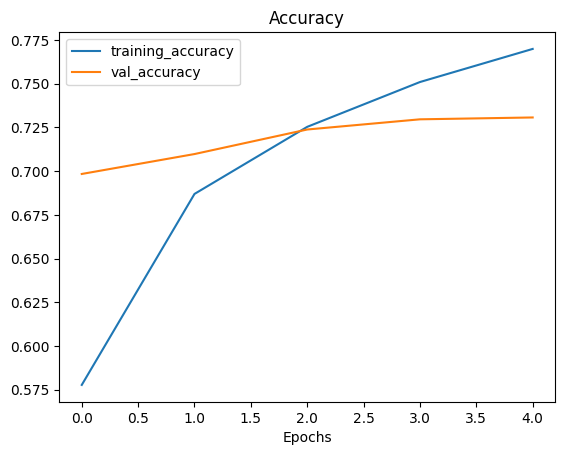

In [24]:
input_shape = IMG_SIZE + (3,)


base_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation(activation="softmax", dtype = tf.float32)(x)
model_b_2 = tf.keras.Model(inputs, outputs)

model_b_2.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

history_b_2 = model_b_2.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[
        create_tensorboard_callback("tensorboard_callback", "07_model_b_2"),
        create_checkpoint_callback("07_model_b_2"),
    ],
)

evaluation_b_2 = model_b_2.evaluate(test_data)

plot_loss_curves(history_b_2)
evaluation_b_2

In [25]:
model_b_2.save("models/07_model_b_2")

In [26]:
model = tf.keras.models.load_model("models/07_model_b_2")

In [27]:
model.evaluate(test_data)

790/790 [==============================] - 64s 75ms/step - loss: 1.0059 - accuracy: 0.7275


[1.0059475898742676, 0.7275247573852539]

In [28]:
!zip -r 07_model_b_2.zip ./models/07_model_b_2

  adding: models/07_model_b_2/ (stored 0%)
  adding: models/07_model_b_2/variables/ (stored 0%)
  adding: models/07_model_b_2/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: models/07_model_b_2/variables/variables.index (deflated 75%)
  adding: models/07_model_b_2/keras_metadata.pb (deflated 96%)
  adding: models/07_model_b_2/saved_model.pb (deflated 92%)
  adding: models/07_model_b_2/assets/ (stored 0%)
  adding: models/07_model_b_2/fingerprint.pb (stored 0%)


## Trying out feature extraction

Saving TensorBoard log files to: tensorboard_callback/07_model_f_1/20240115-163910
Epoch 6/10
2368/2368 [==============================] - 224s 84ms/step - loss: 0.7261 - accuracy: 0.8031 - val_loss: 0.8807 - val_accuracy: 0.7561
Epoch 7/10
2368/2368 [==============================] - 197s 81ms/step - loss: 0.5728 - accuracy: 0.8460 - val_loss: 0.8861 - val_accuracy: 0.7577
Epoch 8/10
2368/2368 [==============================] - 209s 86ms/step - loss: 0.4133 - accuracy: 0.8891 - val_loss: 0.9339 - val_accuracy: 0.7598
Epoch 9/10
2368/2368 [==============================] - 199s 82ms/step - loss: 0.2749 - accuracy: 0.9290 - val_loss: 0.9872 - val_accuracy: 0.7566
Epoch 10/10
790/790 [==============================] - 54s 69ms/step - loss: 1.1362 - accuracy: 0.7427
[1.1361701488494873, 0.742653489112854]


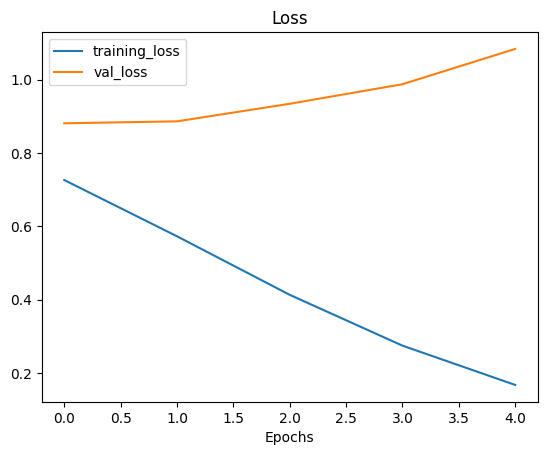

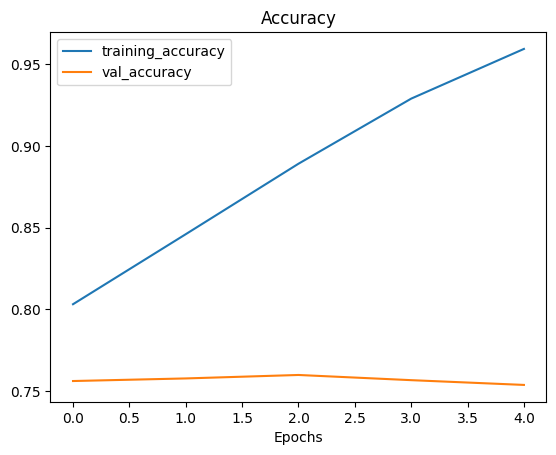

In [23]:
model_f_1 = tf.keras.models.load_model("models/07_model_b_2")
model_f_1.layers[1].trainable = True

for layer in model_f_1.layers[1].layers[:-20]:
  layer.trainable = False

for layer in model_f_1.layers[1].layers[-20:]:
  layer.trainable = True

model_f_1.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics = ["accuracy"],
)

history_f_1 = model_f_1.fit(
    train_data,
    epochs = 10,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    initial_epoch = 5,
    callbacks = [
        create_tensorboard_callback("tensorboard_callback", "07_model_f_1"),
        create_checkpoint_callback("07_model_f_1"),
    ]
)

evaluation_f_1 = model_f_1.evaluate(test_data)
# compare_historys(history_b_2, history_f_1, 5)
plot_loss_curves(history_f_1)
print(evaluation_f_1)

Saving TensorBoard log files to: tensorboard_callback/07_model_f_2/20240115-171032
Epoch 6/10
2368/2368 [==============================] - 228s 86ms/step - loss: 0.7280 - accuracy: 0.8044 - val_loss: 0.9103 - val_accuracy: 0.7492
Epoch 7/10
2368/2368 [==============================] - 208s 85ms/step - loss: 0.6108 - accuracy: 0.8371 - val_loss: 0.8907 - val_accuracy: 0.7606
Epoch 8/10
2368/2368 [==============================] - 199s 81ms/step - loss: 0.5136 - accuracy: 0.8649 - val_loss: 0.8833 - val_accuracy: 0.7598
Epoch 9/10
2368/2368 [==============================] - 201s 82ms/step - loss: 0.4289 - accuracy: 0.8898 - val_loss: 0.9159 - val_accuracy: 0.7556
Epoch 10/10
790/790 [==============================] - 56s 71ms/step - loss: 0.9622 - accuracy: 0.7498
[0.9621953964233398, 0.7498217821121216]


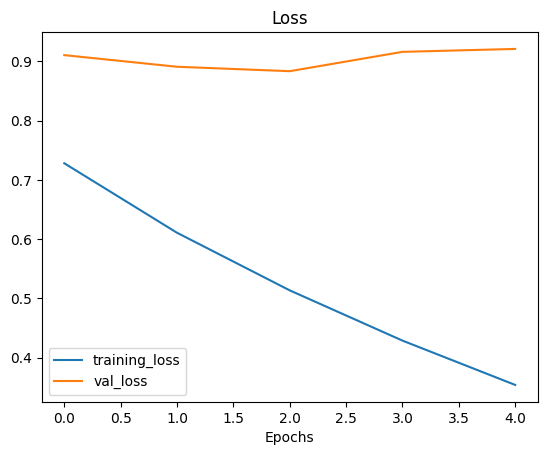

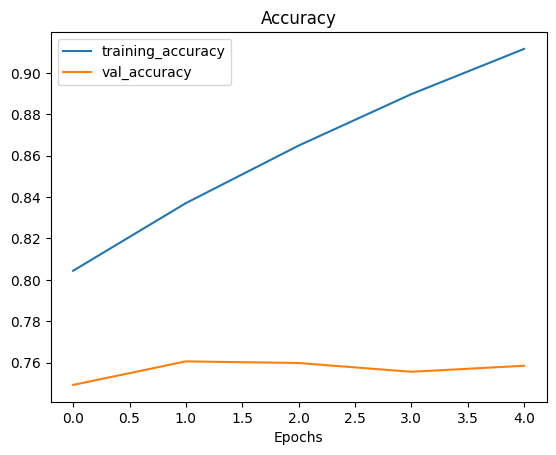

In [16]:
tf.keras.backend.clear_session()
model_f_2 = tf.keras.models.load_model("models/07_model_b_2")
model_f_2.layers[1].trainable = True

for layer in model_f_2.layers[1].layers[:-10]:
  layer.trainable = False

for layer in model_f_2.layers[1].layers[-10:]:
  layer.trainable = True

model_f_2.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics = ["accuracy"],
)

history_f_2 = model_f_2.fit(
    train_data,
    epochs = 10,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    initial_epoch = 5,
    callbacks = [
        create_tensorboard_callback("tensorboard_callback", "07_model_f_2"),
        create_checkpoint_callback("07_model_f_2"),
    ]
)

evaluation_f_2 = model_f_2.evaluate(test_data)
# compare_historys(history_b_2, history_f_2, 5)
plot_loss_curves(history_f_2)
print(evaluation_f_2)

Saving TensorBoard log files to: tensorboard_callback/07_model_f_3/20240115-173341
Epoch 6/10
2368/2368 [==============================] - 230s 87ms/step - loss: 0.8745 - accuracy: 0.7587 - val_loss: 0.8756 - val_accuracy: 0.7577
Epoch 7/10
2368/2368 [==============================] - 204s 84ms/step - loss: 0.6329 - accuracy: 0.8233 - val_loss: 0.8782 - val_accuracy: 0.7632
Epoch 8/10
2368/2368 [==============================] - 203s 82ms/step - loss: 0.4619 - accuracy: 0.8703 - val_loss: 0.8700 - val_accuracy: 0.7707
Epoch 9/10
2368/2368 [==============================] - 208s 85ms/step - loss: 0.3222 - accuracy: 0.9089 - val_loss: 0.9109 - val_accuracy: 0.7619
Epoch 10/10
790/790 [==============================] - 57s 72ms/step - loss: 0.9794 - accuracy: 0.7578
[0.9793716073036194, 0.757821798324585]


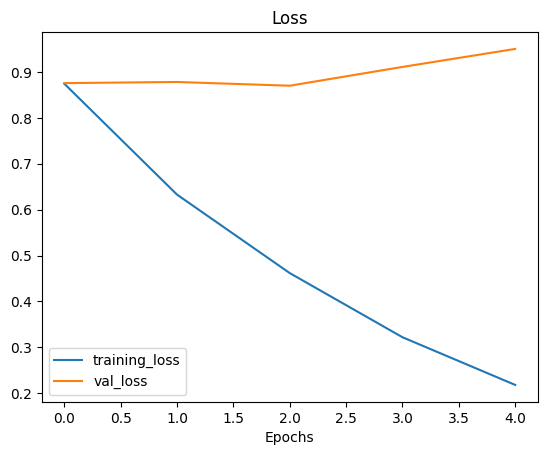

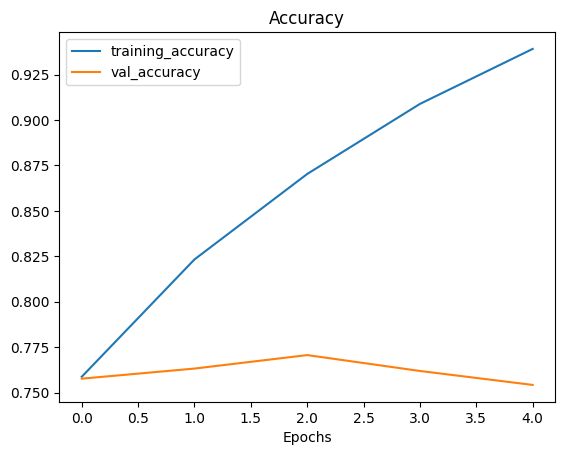

In [16]:
tf.keras.backend.clear_session()
model_f_3 = tf.keras.models.load_model("models/07_model_b_2")
model_f_3.layers[1].trainable = True

for layer in model_f_3.layers[1].layers[:-20]:
  layer.trainable = False

for layer in model_f_3.layers[1].layers[-20:]:
  layer.trainable = True

model_f_3.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer =tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics = ["accuracy"],
)

history_f_3 = model_f_3.fit(
    train_data,
    epochs = 10,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    initial_epoch = 5,
    callbacks = [
        create_tensorboard_callback("tensorboard_callback", "07_model_f_3"),
        create_checkpoint_callback("07_model_f_3"),
    ]
)

evaluation_f_3 = model_f_3.evaluate(test_data)
# compare_historys(history_b_2, history_f_3, 5)
plot_loss_curves(history_f_3)
print(evaluation_f_3)

Saving TensorBoard log files to: tensorboard_callback/07_model_f_4/20240115-175708
Epoch 6/10
2368/2368 [==============================] - 226s 85ms/step - loss: 1.0157 - accuracy: 0.7225 - val_loss: 0.9378 - val_accuracy: 0.7474
Epoch 7/10
2368/2368 [==============================] - 202s 83ms/step - loss: 0.7056 - accuracy: 0.8013 - val_loss: 0.8925 - val_accuracy: 0.7595
Epoch 8/10
2368/2368 [==============================] - 209s 86ms/step - loss: 0.5092 - accuracy: 0.8524 - val_loss: 0.9062 - val_accuracy: 0.7516
Epoch 9/10
2368/2368 [==============================] - 198s 81ms/step - loss: 0.3621 - accuracy: 0.8935 - val_loss: 0.9731 - val_accuracy: 0.7582
Epoch 10/10
790/790 [==============================] - 58s 73ms/step - loss: 1.0073 - accuracy: 0.7535
[1.0072566270828247, 0.7535049319267273]


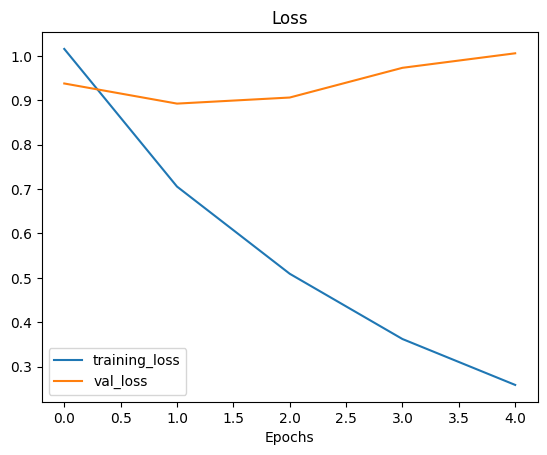

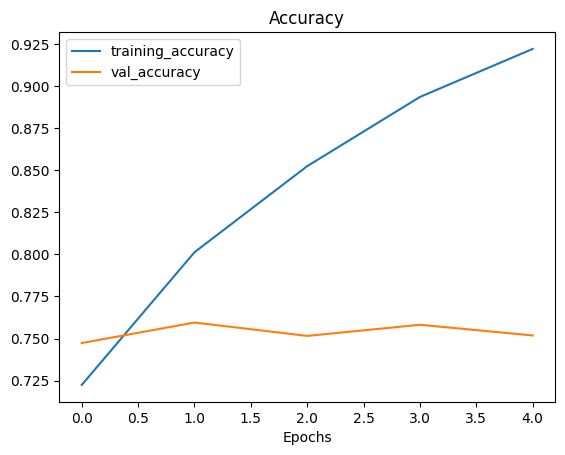

In [ ]:
tf.keras.backend.clear_session()
model_f_4 = tf.keras.models.load_model("models/07_model_b_2")
model_f_4.layers[1].trainable = True

for layer in model_f_4.layers[1].layers[:-20]:
  layer.trainable = False

for layer in model_f_4.layers[1].layers[-20:]:
  layer.trainable = True

model_f_4.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer =tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = ["accuracy"],
)

history_f_4 = model_f_4.fit(
    train_data,
    epochs = 10,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    initial_epoch = 5,
    callbacks = [
        create_tensorboard_callback("tensorboard_callback", "07_model_f_4"),
        create_checkpoint_callback("07_model_f_4"),
    ]
)

evaluation_f_4 = model_f_4.evaluate(test_data)
# compare_historys(history_b_2, history_f_4, 5)
plot_loss_curves(history_f_4)
print(evaluation_f_4)

Saving TensorBoard log files to: tensorboard_callback/07_model_f_5/20240115-181743
Epoch 6/10
2368/2368 [==============================] - 219s 83ms/step - loss: 0.8727 - accuracy: 0.7594 - val_loss: 0.8864 - val_accuracy: 0.7569
Epoch 7/10
2368/2368 [==============================] - 200s 82ms/step - loss: 0.6024 - accuracy: 0.8323 - val_loss: 0.9096 - val_accuracy: 0.7540
Epoch 8/10
2368/2368 [==============================] - 201s 82ms/step - loss: 0.4076 - accuracy: 0.8856 - val_loss: 0.8961 - val_accuracy: 0.7699
Epoch 9/10
2368/2368 [==============================] - 202s 83ms/step - loss: 0.2641 - accuracy: 0.9267 - val_loss: 0.9655 - val_accuracy: 0.7556
Epoch 10/10
790/790 [==============================] - 57s 72ms/step - loss: 1.0579 - accuracy: 0.7480
[1.0579084157943726, 0.7479603886604309]


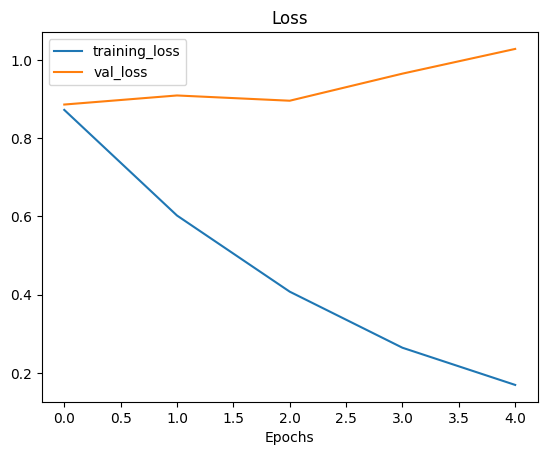

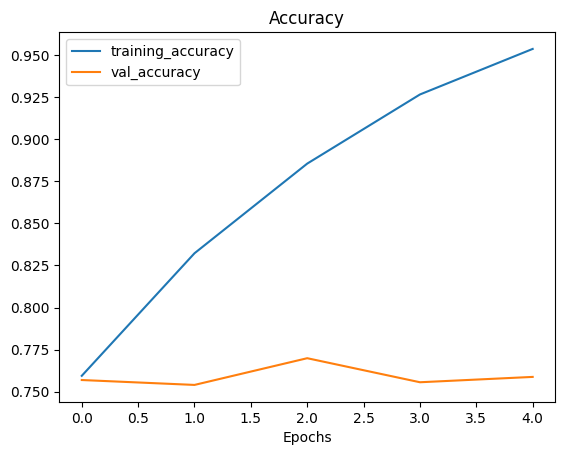

In [19]:
tf.keras.backend.clear_session()
model_f_5 = tf.keras.models.load_model("models/07_model_b_2")
model_f_5.layers[1].trainable = True

for layer in model_f_5.layers[1].layers[:-10]:
  layer.trainable = False

for layer in model_f_5.layers[1].layers[-10:]:
  layer.trainable = True

model_f_5.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer =tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics = ["accuracy"],
)

history_f_5 = model_f_5.fit(
    train_data,
    epochs = 10,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    initial_epoch = 5,
    callbacks = [
        create_tensorboard_callback("tensorboard_callback", "07_model_f_5"),
        create_checkpoint_callback("07_model_f_5"),
    ]
)

evaluation_f_5 = model_f_5.evaluate(test_data)
# compare_historys(history_b_2, history_f_5, 5)
plot_loss_curves(history_f_5)
print(evaluation_f_5)

Saving TensorBoard log files to: tensorboard_callback/07_model_f_6/20240115-183748
Epoch 6/10
2368/2368 [==============================] - 232s 88ms/step - loss: 0.8766 - accuracy: 0.7591 - val_loss: 0.8350 - val_accuracy: 0.7683
Epoch 7/10
2368/2368 [==============================] - 220s 91ms/step - loss: 0.5890 - accuracy: 0.8351 - val_loss: 0.7995 - val_accuracy: 0.7794
Epoch 8/10
2368/2368 [==============================] - 230s 95ms/step - loss: 0.3579 - accuracy: 0.8991 - val_loss: 0.8777 - val_accuracy: 0.7683
Epoch 9/10
2368/2368 [==============================] - 209s 86ms/step - loss: 0.2039 - accuracy: 0.9412 - val_loss: 0.9425 - val_accuracy: 0.7651
Epoch 10/10
790/790 [==============================] - 57s 71ms/step - loss: 1.0593 - accuracy: 0.7600
[1.0592764616012573, 0.759960412979126]


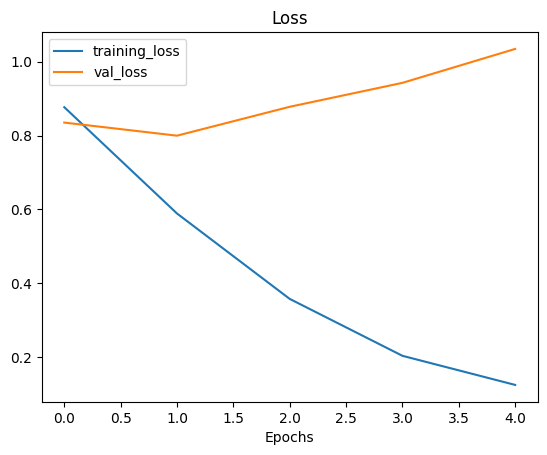

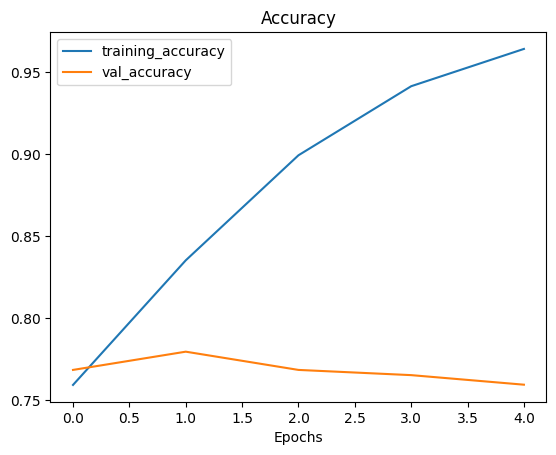

In [ ]:
tf.keras.backend.clear_session()
model_f_6 = tf.keras.models.load_model("models/07_model_b_2")
model_f_6.layers[1].trainable = True

for layer in model_f_6.layers[1].layers[:-30]:
  layer.trainable = False

for layer in model_f_6.layers[1].layers[-30:]:
  layer.trainable = True

model_f_6.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer =tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics = ["accuracy"],
)

history_f_6 = model_f_6.fit(
    train_data,
    epochs = 10,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    initial_epoch = 5,
    callbacks = [
        create_tensorboard_callback("tensorboard_callback", "07_model_f_6"),
        create_checkpoint_callback("07_model_f_6"),
    ]
)

evaluation_f_6 = model_f_6.evaluate(test_data)
# compare_historys(history_b_2, history_f_6, 5)
plot_loss_curves(history_f_6)
print(evaluation_f_6)

Saving TensorBoard log files to: tensorboard_callback/07_model_f_7/20240116-013310
Epoch 6/10
2368/2368 [==============================] - 1222s 511ms/step - loss: 0.8921 - accuracy: 0.7552 - val_loss: 0.8004 - val_accuracy: 0.7778
Epoch 7/10
2368/2368 [==============================] - 1206s 508ms/step - loss: 0.5732 - accuracy: 0.8394 - val_loss: 0.7726 - val_accuracy: 0.7881
Epoch 8/10
2368/2368 [==============================] - 1188s 501ms/step - loss: 0.3360 - accuracy: 0.9046 - val_loss: 0.8098 - val_accuracy: 0.7805
Epoch 9/10
2368/2368 [==============================] - 1186s 500ms/step - loss: 0.1850 - accuracy: 0.9464 - val_loss: 0.8628 - val_accuracy: 0.7752
Epoch 10/10
790/790 [==============================] - 327s 414ms/step - loss: 0.9874 - accuracy: 0.7741
[0.9873867630958557, 0.7740989923477173]


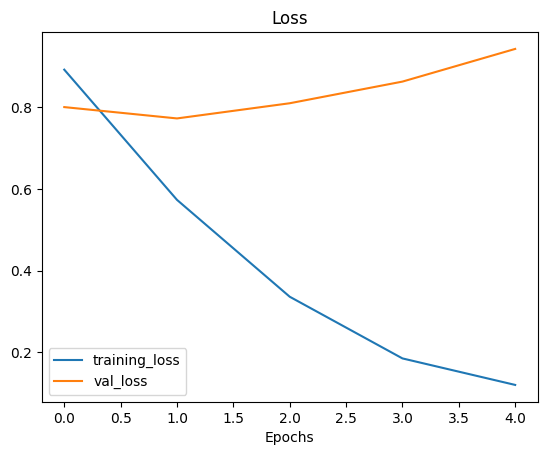

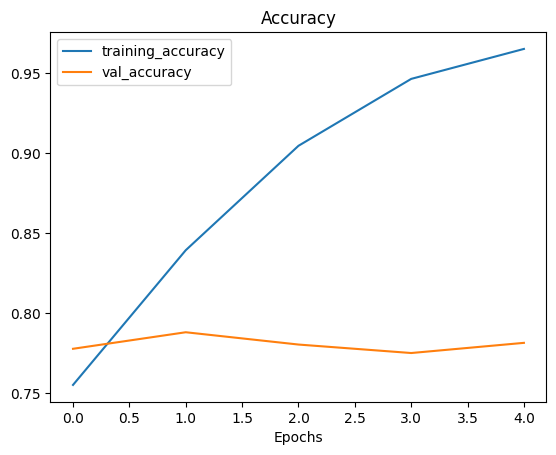

In [21]:
tf.keras.backend.clear_session()
model_f_7 = tf.keras.models.load_model("models/07_model_b_2")
model_f_7.layers[1].trainable = True

for layer in model_f_7.layers[1].layers[:-40]:
  layer.trainable = False

for layer in model_f_7.layers[1].layers[-40:]:
  layer.trainable = True

model_f_7.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer =tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
    metrics = ["accuracy"],
)

history_f_7 = model_f_7.fit(
    train_data,
    epochs = 10,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    initial_epoch = 5,
    callbacks = [
        create_tensorboard_callback("tensorboard_callback", "07_model_f_7"),
        create_checkpoint_callback("07_model_f_7"),
    ]
)

evaluation_f_7 = model_f_7.evaluate(test_data)
# compare_historys(history_b_2, history_f_7, 5)
plot_loss_curves(history_f_7)
print(evaluation_f_7)

Saving TensorBoard log files to: tensorboard_callback/07_model_f_8/20240116-031859
Epoch 6/10
2368/2368 [==============================] - 1253s 520ms/step - loss: 0.8962 - accuracy: 0.7555 - val_loss: 0.7950 - val_accuracy: 0.7807
Epoch 7/10
2368/2368 [==============================] - 1215s 513ms/step - loss: 0.5906 - accuracy: 0.8344 - val_loss: 0.7890 - val_accuracy: 0.7797
Epoch 8/10
2368/2368 [==============================] - 1221s 515ms/step - loss: 0.3617 - accuracy: 0.8966 - val_loss: 0.8128 - val_accuracy: 0.7812
Epoch 9/10
2368/2368 [==============================] - 1220s 515ms/step - loss: 0.2097 - accuracy: 0.9390 - val_loss: 0.8589 - val_accuracy: 0.7926
Epoch 10/10
790/790 [==============================] - 322s 407ms/step - loss: 0.9536 - accuracy: 0.7775
[0.9536285400390625, 0.7775445580482483]


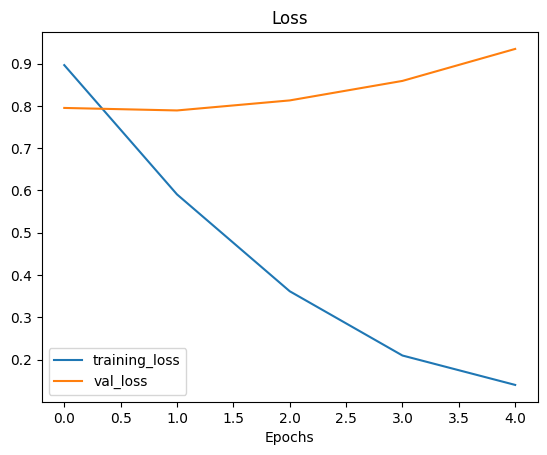

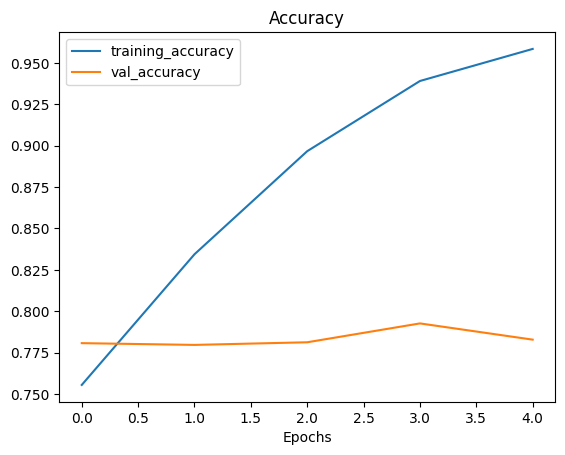

In [22]:
tf.keras.backend.clear_session()
model_f_8 = tf.keras.models.load_model("models/07_model_b_2")
model_f_8.layers[1].trainable = True

for layer in model_f_8.layers[1].layers[:-50]:
  layer.trainable = False

for layer in model_f_8.layers[1].layers[-50:]:
  layer.trainable = True

model_f_8.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer =tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
    metrics = ["accuracy"],
)

history_f_8 = model_f_8.fit(
    train_data,
    epochs = 10,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    initial_epoch = 5,
    callbacks = [
        create_tensorboard_callback("tensorboard_callback", "07_model_f_8"),
        create_checkpoint_callback("07_model_f_8"),
    ]
)

evaluation_f_8 = model_f_8.evaluate(test_data)
# compare_historys(history_b_2, history_f_8, 5)
plot_loss_curves(history_f_8)
print(evaluation_f_8)

Saving TensorBoard log files to: tensorboard_callback/07_model_f_9/20240116-050655
Epoch 6/10
2368/2368 [==============================] - 1291s 534ms/step - loss: 0.9122 - accuracy: 0.7507 - val_loss: 0.7342 - val_accuracy: 0.7963
Epoch 7/10
2368/2368 [==============================] - 1219s 514ms/step - loss: 0.5566 - accuracy: 0.8441 - val_loss: 0.7456 - val_accuracy: 0.7971
Epoch 8/10
2368/2368 [==============================] - 1275s 538ms/step - loss: 0.3030 - accuracy: 0.9114 - val_loss: 0.8331 - val_accuracy: 0.7865
Epoch 9/10
2368/2368 [==============================] - 1271s 536ms/step - loss: 0.1658 - accuracy: 0.9509 - val_loss: 0.8573 - val_accuracy: 0.7858
Epoch 10/10
790/790 [==============================] - 293s 370ms/step - loss: 0.9540 - accuracy: 0.7779
[0.9539887309074402, 0.7779009938240051]


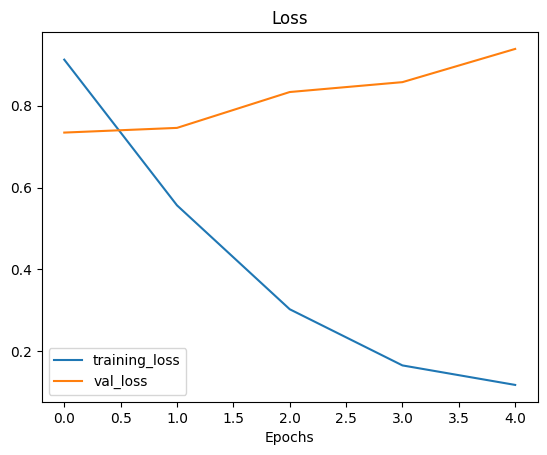

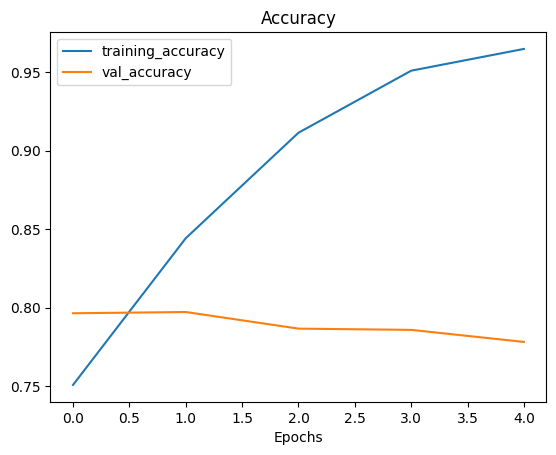

In [23]:
tf.keras.backend.clear_session()
model_f_9 = tf.keras.models.load_model("models/07_model_b_2")
model_f_9.layers[1].trainable = True

for layer in model_f_9.layers[1].layers[:-75]:
  layer.trainable = False

for layer in model_f_9.layers[1].layers[-75:]:
  layer.trainable = True

model_f_9.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer =tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
    metrics = ["accuracy"],
)

history_f_9 = model_f_9.fit(
    train_data,
    epochs = 10,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    initial_epoch = 5,
    callbacks = [
        create_tensorboard_callback("tensorboard_callback", "07_model_f_9"),
        create_checkpoint_callback("07_model_f_9"),
    ]
)

evaluation_f_9 = model_f_9.evaluate(test_data)
# compare_historys(history_b_2, history_f_9, 5)
plot_loss_curves(history_f_9)
print(evaluation_f_9)

In [28]:
tf.keras.backend.clear_session()
model_f_7 = tf.keras.models.load_model("models/07_model_b_2")
model_f_7.layers[1].trainable = True

for layer in model_f_7.layers[1].layers[:-40]:
  layer.trainable = False

for layer in model_f_7.layers[1].layers[-40:]:
  layer.trainable = True

model_f_7.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer =tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
    metrics = ["accuracy"],
)

model_f_7.load_weights("checkpoints/07_model_f_7/checkpoint.ckpt")
evaluation_f_7 = model_f_7.evaluate(test_data)
# compare_historys(history_b_2, history_f_7, 5)
# plot_loss_curves(history_f_7)
print(evaluation_f_7)

790/790 [==============================] - 340s 422ms/step - loss: 0.8016 - accuracy: 0.7806
[0.801618754863739, 0.7805940508842468]


In [30]:
tf.keras.backend.clear_session()
model_f_8 = tf.keras.models.load_model("models/07_model_b_2")
model_f_8.layers[1].trainable = True

for layer in model_f_8.layers[1].layers[:-50]:
  layer.trainable = False

for layer in model_f_8.layers[1].layers[-50:]:
  layer.trainable = True

model_f_8.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer =tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
    metrics = ["accuracy"],
)

model_f_8.load_weights("checkpoints/07_model_f_8/checkpoint.ckpt")

evaluation_f_8 = model_f_8.evaluate(test_data)
# compare_historys(history_b_2, history_f_8, 5)
# plot_loss_curves(history_f_8)
print(evaluation_f_8)

790/790 [==============================] - 341s 424ms/step - loss: 0.8920 - accuracy: 0.7834
[0.8919844031333923, 0.7834059596061707]


In [ ]:
tf.keras.backend.clear_session()
model_f_9 = tf.keras.models.load_model("models/07_model_b_2")
model_f_9.layers[1].trainable = True

for layer in model_f_9.layers[1].layers[:-75]:
  layer.trainable = False

for layer in model_f_9.layers[1].layers[-75:]:
  layer.trainable = True

model_f_9.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer =tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
    metrics = ["accuracy"],
)

model_f_9.load_weights("checkpoints/07_model_f_9/checkpoint.ckpt")

evaluation_f_9 = model_f_9.evaluate(test_data)
# compare_historys(history_b_2, history_f_9, 5)
# plot_loss_curves(history_f_9)
print(evaluation_f_9)

790/790 [==============================] - 339s 421ms/step - loss: 0.7768 - accuracy: 0.7836
[0.7767699360847473, 0.7836435437202454]


Saving TensorBoard log files to: tensorboard_callback/07_model_f_9/20240116-110332
Epoch 6/10
2368/2368 [==============================] - 1302s 537ms/step - loss: 0.7322 - accuracy: 0.8008 - val_loss: 0.8447 - val_accuracy: 0.7606
Epoch 7/10
2368/2368 [==============================] - 1260s 531ms/step - loss: 0.4690 - accuracy: 0.8706 - val_loss: 0.8584 - val_accuracy: 0.7704
Epoch 8/10
2368/2368 [==============================] - 1251s 528ms/step - loss: 0.2325 - accuracy: 0.9366 - val_loss: 1.0027 - val_accuracy: 0.7587
Epoch 9/10
2368/2368 [==============================] - 1259s 531ms/step - loss: 0.0972 - accuracy: 0.9749 - val_loss: 1.1274 - val_accuracy: 0.7553
Epoch 10/10
790/790 [==============================] - 319s 404ms/step - loss: 1.3033 - accuracy: 0.7473
[1.303274393081665, 0.7472871541976929]


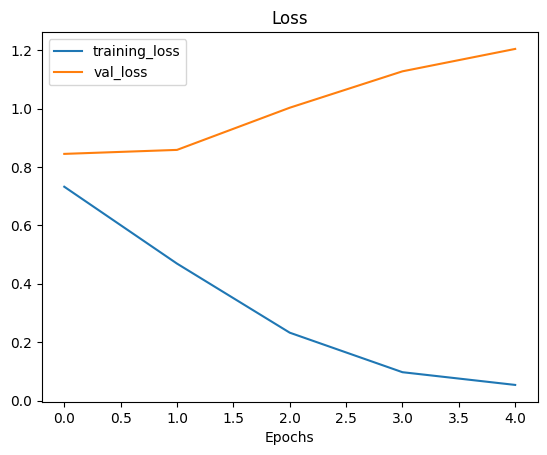

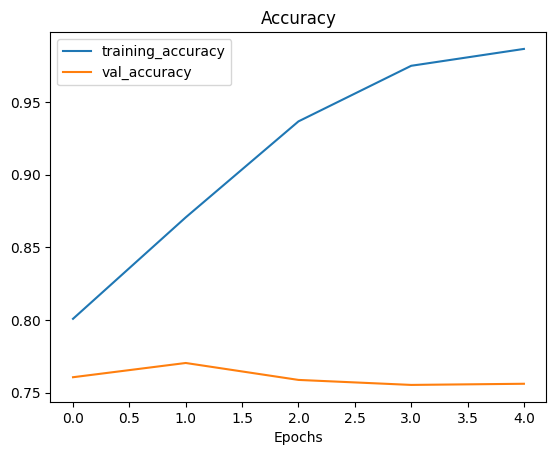

In [36]:
model_f_8 = tf.keras.models.load_model("models/07_model_b_2")
model_f_8.layers[1].trainable = True

for layer in model_f_8.layers[1].layers[:-50]:
  layer.trainable = False

for layer in model_f_8.layers[1].layers[-50:]:
  layer.trainable = True

model_f_8.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer =tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    metrics = ["accuracy"],
)

history_f_8 = model_f_8.fit(
    train_data,
    epochs = 10,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    initial_epoch = 5,
    callbacks = [
        create_tensorboard_callback("tensorboard_callback", "07_model_f_8"),
        create_checkpoint_callback("07_model_f_8"),
    ]
)

evaluation_f_8 = model_f_8.evaluate(test_data)
# compare_historys(history_b_2, history_f_8, 5)
plot_loss_curves(history_f_8)
print(evaluation_f_8)

In [37]:
model_test = tf.keras.models.load_model("models/07_model_b_2")
model_test.evaluate(test_data)

790/790 [==============================] - 308s 378ms/step - loss: 1.0061 - accuracy: 0.7276


[1.0060515403747559, 0.7276435494422913]

In [41]:
model_f_11 = tf.keras.models.load_model("models/07_model_b_2")
model_f_11.layers[1].trainable = True

for layer in model_f_11.layers[1].layers[:-50]:
  layer.trainable = False

for layer in model_f_11.layers[1].layers[-50:]:
  layer.trainable = True

model_f_11.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer =tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    metrics = ["accuracy"],
)

model_f_11.load_weights("checkpoints/07_model_f_11/checkpoint.ckpt")

evaluation_f_11 = model_f_11.evaluate(test_data)
# compare_historys(history_b_2, history_f_11, 5)
# plot_loss_curves(history_f_11)
print(evaluation_f_11)

790/790 [==============================] - 357s 434ms/step - loss: 0.9080 - accuracy: 0.7601
[0.9080153107643127, 0.7601187825202942]


In [20]:
tf.keras.backend.clear_session()
model_f_9 = tf.keras.models.load_model("models/07_model_b_2")
model_f_9.layers[1].trainable = True

for layer in model_f_9.layers[1].layers[:-75]:
  layer.trainable = False

for layer in model_f_9.layers[1].layers[-75:]:
  layer.trainable = True

model_f_9.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer =tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
    metrics = ["accuracy"],
)

model_f_9.load_weights("checkpoints/07_model_f_9/checkpoint.ckpt")

evaluation_f_9 = model_f_9.evaluate(test_data)
# compare_historys(history_b_2, history_f_9, 5)
# plot_loss_curves(history_f_9)
print(evaluation_f_9)

KeyboardInterrupt: 

In [17]:
tf.keras.backend.clear_session()
model_f_12 = tf.keras.models.load_model("models/07_model_b_2")
model_f_12.layers[1].trainable = True

# for layer in model_f_12.layers[1].layers[:-75]:
#   layer.trainable = False

for layer in model_f_12.layers[1].layers:
  layer.trainable = True

model_f_12.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer =tf.keras.optimizers.legacy.Adam(learning_rate=0.00001),
    metrics = ["accuracy"],
)

history_f_12 = model_f_12.fit(
    train_data,
    epochs = 20,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    initial_epoch = 5,
    callbacks = [
        create_tensorboard_callback("tensorboard_callback", "07_model_f_12"),
        create_checkpoint_callback("07_model_f_12"),
        tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2),
    ]
)

evaluation_f_12 = model_f_12.evaluate(test_data)
# compare_historys(history_b_2, history_f_12, 5)
plot_loss_curves(history_f_12)
print(evaluation_f_12)

Saving TensorBoard log files to: tensorboard_callback/07_model_f_12/20240117-134101
Epoch 6/20


2024-01-17 13:41:10.804186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


  46/2368 [..............................] - ETA: 1:26:37 - loss: 0.7575 - accuracy: 0.8077

KeyboardInterrupt: 